# STAT3612 Lecture 6 - Generalized Additive Models

[Dr. Aijun Zhang](http://www.statsoft.org) - [STAT3612 Statistical Machine Learning](https://ajzhanghku.github.io/Stat3612/)

6 October 2020

In [1]:
import numpy as np
from patsy import dmatrix
from matplotlib import pyplot as plt

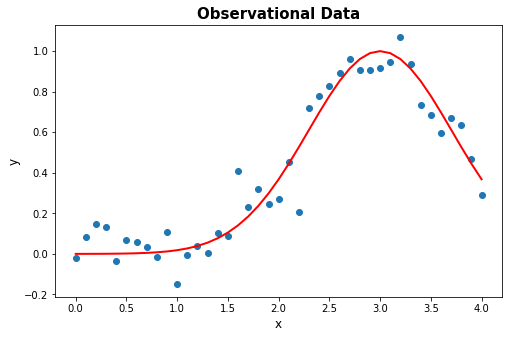

In [2]:
# DGM 1: Truncated normal density

def ffun(x):
    return np.exp(-(x-3)**2)

nn = 41
xx = np.linspace(0, 4, nn)
np.random.seed(2019)
yy = ffun(xx) + 0.1*np.random.normal(0, 1, len(xx))

plt.figure(1, figsize=(8, 5))
plt.plot(xx, yy, 'o')
plt.plot(xx, ffun(xx), color="red", LineWidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Observational Data', fontsize=15, fontweight="bold")
plt.show()

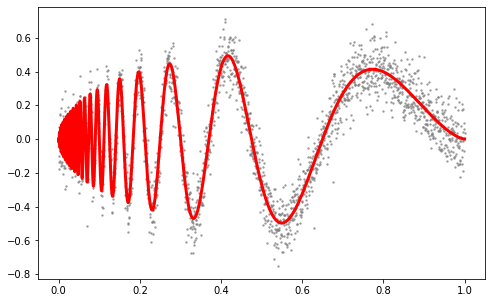

In [3]:
# DGM 2: Doppler Function
def doppler(DataNum, noise_level):
    x = np.linspace(0, 1, DataNum)
    y_wo_noise = np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+0.05))
    y_with_noise = y_wo_noise + noise_level*np.random.normal(0, 1, DataNum) 
    return x, y_wo_noise, y_with_noise

n = 2000
x, y_wo_noise, y_with_noise = doppler(n, 0.1)
plt.figure(1, figsize=(8, 5))
plt.plot(x, y_with_noise, '.', MarkerSize=3,color='gray',alpha=0.6)
plt.plot(x, y_wo_noise, color="red", LineWidth=3)
plt.show()

# HF Filtering

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


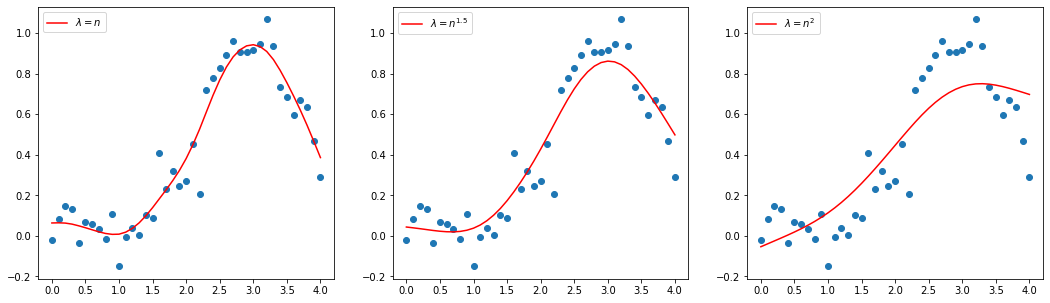

In [4]:
import statsmodels.api as sm

lambs = [nn,nn**1.5,nn**2]
lambs_sym = ['n','n^{1.5}','n^2']
trends = []

for lamb in lambs:
    trends.append(sm.tsa.filters.hpfilter(yy, lamb)[1])
    
fig,axes = plt.subplots(1,3,figsize=(18,5))
for i in range(3):
    plt.subplot(axes[i])
    plt.plot(xx, yy, 'o')
    # plt.plot(xx,ffun(xx), color="red", LineWidth=3)
    plt.plot(xx, trends[i], color="red", label='$\lambda={}$'.format(lambs_sym[i]))
    plt.legend()

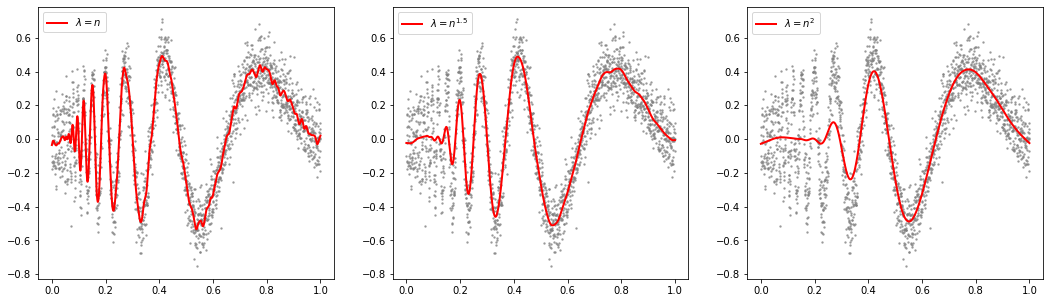

In [5]:
# doppler function
lambs = [n,n**1.5,n**2]
lambs_sym = ['n','n^{1.5}','n^2']
trends = []

for lamb in lambs:
    trends.append(sm.tsa.filters.hpfilter(y_with_noise, lamb)[1])
    
fig,axes = plt.subplots(1,3,figsize=(18,5))
for i in range(3):
    plt.subplot(axes[i])
    plt.plot(x, y_with_noise, '.', MarkerSize=3,color='gray',alpha=0.6)
    # plt.plot(x,y_wo_noise, color="red", LineWidth=3)
    plt.plot(x, trends[i], color="red", LineWidth=2, label='$\lambda={}$'.format(lambs_sym[i]))
    plt.legend()

# $L_0$ B-Splines

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted

def diff_matrix(order, knot_num):
    results = [] # a container to collect the rows
    n_rows = order + 2
    for _ in range(n_rows): 
        row = [1] # a starter 1 in the row
        if results: # then we're in the second row or beyond
            last_row = results[-1] # reference the previous row
            row.extend([sum(pair) for pair in zip(last_row, last_row[1:])])
            row.append(1)
        results.append(row) # add the row to the results.

    diss_operator = [] # a container to collect the rows
    for i, item in enumerate(np.array(row)):
        diss_operator.append(item * (-1) ** i)
    diss_operator.reverse()
    D = np.zeros((knot_num, knot_num + order + 1), dtype=np.float32)
    for i in range(knot_num):
        D[i,i:(i+order+2)] = diss_operator
    return D

class L0BSplines(BaseEstimator, RegressorMixin):
    def __init__(self, knot_num=100, degree=2, reg_lambda=0.1, epsilon=0.00001, threshold=0.99, maxiter=10):

        self.knot_num = knot_num
        self.degree = degree
        self.reg_lambda = reg_lambda
        self.epsilon = epsilon
        self.threshold = threshold
        self.maxiter = maxiter

    def fit(self, x, y):

        knots = list(np.linspace(0, 1, self.knot_num + 2, dtype=np.float32)[1:-1])
        xphi = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1",
                       {"x": x, "knots": knots, "degree": self.degree})
        basis = xphi.view() 
        D = diff_matrix(self.degree, self.knot_num)
        w = np.ones([self.knot_num], dtype=np.float32) 
        W = np.diag(w)
        for i in range(self.maxiter):
            update_a = np.dot(np.linalg.inv(np.dot(basis.T, basis) + self.reg_lambda * np.dot(np.dot(D.T, W), D)), np.dot(basis.T, y))
            update_w = 1 / (np.dot(D, update_a)**2 + self.epsilon**2)
            W = np.diag(update_w.reshape([-1]))
        self.selected_knots_ = np.array(knots)[np.reshape(update_w * np.dot(D, update_a)**2 > self.threshold, [-1])]
        
        selected_xphi = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1", 
               {"x": x, "knots": list(self.selected_knots_), "degree": self.degree})
        selected_basis = selected_xphi.view() 
        self.coef_ = np.dot(np.linalg.inv(np.dot(selected_basis.T, selected_basis)), np.dot(selected_basis.T, y))
        return self
    
    def predict(self, x):
        
        check_is_fitted(self, "coef_")
        xphi = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1", 
               {"x": x, "knots": list(self.selected_knots_), "degree": self.degree})
        self.basis_ = xphi.view() 
        return np.dot(self.basis_, self.coef_)

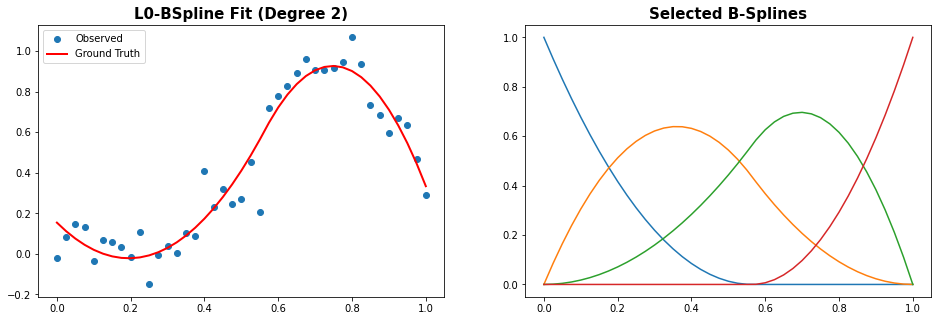

In [7]:
# data should be normalized into [0,1] before the fitting
xx_norm = (xx-xx.min())/(xx.max()-xx.min())
order = 2
l0bs = L0BSplines(degree = order)
l0bs.fit(xx_norm,yy)
yy_pred_l0bs = l0bs.predict(xx_norm)
basis = l0bs.basis_

# visualization
fig,axes = plt.subplots(1,2,figsize=(16, 5))
plt.subplot(axes[0])
plt.plot(xx_norm,yy, 'o')
# plt.plot(xx_norm,ffun(xx), color="red", LineWidth=3)
plt.plot(xx_norm,yy_pred_l0bs, color='red', LineWidth=2)
plt.title('L0-BSpline Fit (Degree '+ str(order) + ')', fontsize=15, fontweight="bold")
plt.legend(["Observed", "Ground Truth", "Prediction"])

plt.subplot(axes[1])
plt.title('Selected B-Splines',fontsize=15, fontweight="bold")
plt.plot(xx_norm,basis)

plt.show()

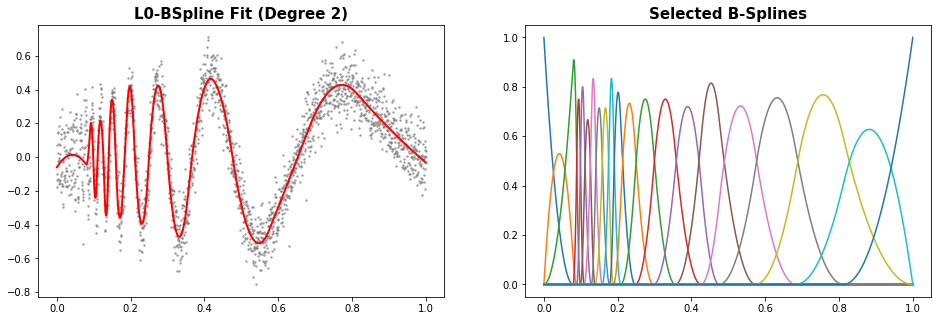

In [8]:
order = 2
l0bs = L0BSplines(degree = order)
l0bs.fit(x,y_with_noise)
y_pred_l0bs = l0bs.predict(x)
basis = l0bs.basis_

# visualization
fig,axes = plt.subplots(1,2,figsize=(16, 5))
plt.subplot(axes[0])
plt.plot(x,y_with_noise, '.', MarkerSize=3,color='gray',alpha=0.6)
#plt.plot(x,y_wo_noise, color="red", LineWidth=3)
plt.plot(x,y_pred_l0bs, color='red', LineWidth=2)
plt.title('L0-BSpline Fit (Degree '+ str(order) +')', fontsize=15, fontweight="bold")

plt.subplot(axes[1])
plt.title('Selected B-Splines',fontsize=15, fontweight="bold")
plt.plot(x,basis)

plt.show()

# Penalized B-Splines in `pyGAM`


In [9]:
!pip install -U pygam

     |████████████████████████████████| 1.8MB 4.4MB/s 


In [10]:
from pygam import LinearGAM, s

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


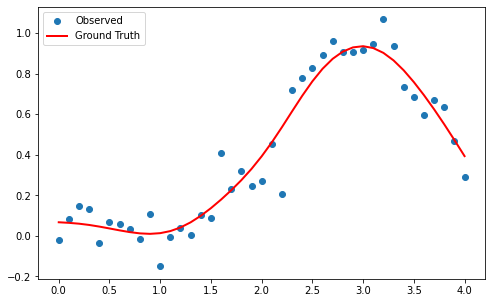

In [11]:
gam_pbs = LinearGAM(s(0, penalties='derivative'))
gam_pbs.gridsearch(xx.reshape(-1,1),yy)
yy_pred_pbs = gam_pbs.predict(xx.reshape(-1,1))

plt.figure(figsize=(8,5))
plt.plot(xx,yy, 'o')
#plt.plot(xx,ffun(xx), color="red", LineWidth=3)
plt.plot(xx,yy_pred_pbs, color='red', LineWidth=2)
plt.legend(["Observed", "Ground Truth", "Prediction"])
plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


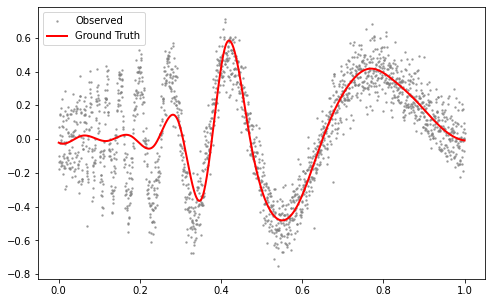

In [12]:
gam_pbs = LinearGAM(s(0, penalties='derivative'))
gam_pbs.gridsearch(x.reshape(-1,1),y_with_noise)
y_pred_pbs = gam_pbs.predict(x.reshape(-1,1))

plt.figure(figsize=(8,5))
plt.plot(x,y_with_noise, '.', MarkerSize=3,color='gray',alpha=0.6)
#plt.plot(x,y_wo_noise, color="red", LineWidth=3)
plt.plot(x,y_pred_pbs, color='red', LineWidth=2)
plt.legend(["Observed", "Ground Truth", "Prediction"])
plt.show()

# Generalized Additive Model

In [13]:
from pygam import LinearGAM,LogisticGAM,l,s,f
from pygam.datasets import wage

In [14]:
feature_names = ['year','age','education']
X,y = wage(return_X_y=True)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


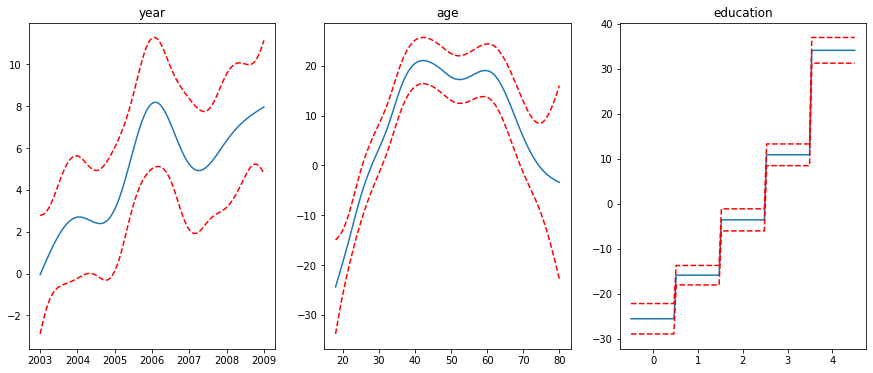

In [15]:
linear_gam = LinearGAM(s(0)+s(1)+f(2))
linear_gam.gridsearch(X,y)

fig, axes = plt.subplots(1, 3,figsize=(15,6))
titles = feature_names

for i, ax in enumerate(axes):
    XX = linear_gam.generate_X_grid(term=i)
    pdep, confi = linear_gam.partial_dependence(term=i, width=.95)

    plt.subplot(axes[i])
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c='r', ls='--')
    plt.title(titles[i])

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


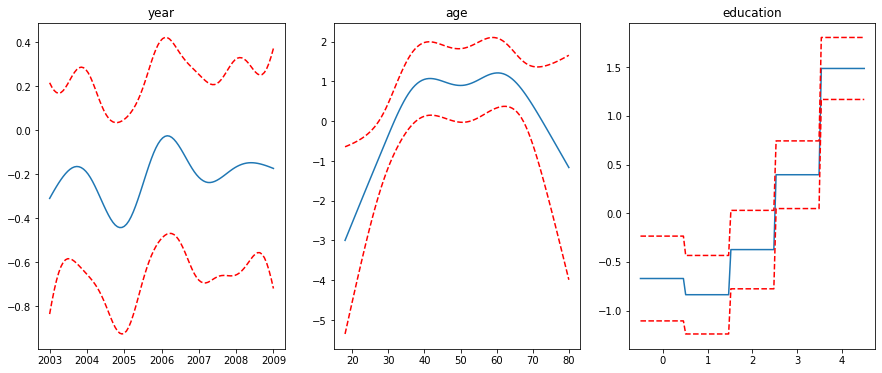

In [16]:
# create a new feature for classification
y_cls = (y>250).astype(int)
logit_gam = LogisticGAM(s(0)+s(1)+f(2))
logit_gam.gridsearch(X,y_cls)

fig, axes = plt.subplots(1, 3,figsize=(15,6))
titles = feature_names

for i, ax in enumerate(axes):
    XX = logit_gam.generate_X_grid(term=i)
    pdep, confi = logit_gam.partial_dependence(term=i, width=.95)

    plt.subplot(axes[i])
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c='r', ls='--')
    plt.title(titles[i])